In [1]:
import numpy as np
import pylab as plt
from bayes_tec.utils.data_utils import make_coord_array
from bayes_tec.kernels import ThinLayer

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/multipledispatch-0.4.9-py3.6.egg/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Identity, NoneType, Kernel, InducingPoints], [Gaussian, Linear, NoneType, Sum, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


In [2]:
def f(x,k,a,x0):
    kz = k[:,2]
    x_ = x[:,0] - (a + (x0[:,2] - x[:,2])) * np.sqrt(1 - kz**2)/kz
    y_ = x[:,1] - (a + (x0[:,2] - x[:,2])) * np.sqrt(1 - kz**2)/kz
    z_ = np.tile(a + x0[:,2],(x.shape[0],))
    return np.stack([x_,y_,z_],axis=1)

def M32(x1,x2,sigma,l):
    x1 /= l[None,:]
    x2 /= l[None,:]
    dx2 = np.sum(np.square(x1[:,:,None] - x2.T[None,:,:]),axis=1)
    d = np.sqrt(3) * np.sqrt(dx2)
    return sigma**2 * (1 + d)*np.exp(-d)

def _kern(X1,X2,a,b,x0,sigma,l):
    x1,k1 = X1[:,:3],X1[:,3:6]
    x2,k2 = X2[:,:3],X2[:,3:6]
    x1 = f(x1,k1,a,x0)
    x2 = f(x2,k2,a,x0)
    sec1 = 1./k1[:,2]
    sec2 = 1./k2[:,2]
    
    b2exp2rho = b**2 * 1e-6# (b * 1e3)**2 * (1e10 /1e16)**2
    
    return b2exp2rho * M32(x1,x2,sigma,l)

def kern(X,a,b,x0,sigma,l):
    X0 = np.concatenate([np.tile(x0,(X.shape[0],1)),X[:,3:6]],axis=1)
    Ksym = _kern(X,X0,a,b,x0,sigma,l)
    Ksym += Ksym.T
    return _kern(X,X,a,b,x0,sigma,l)+_kern(X0,X0,a,b,x0,sigma,l) - Ksym

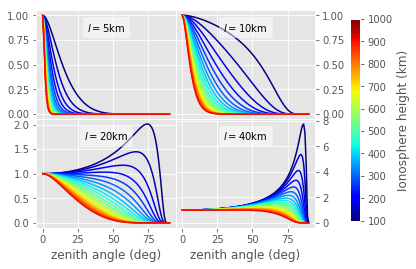

In [3]:
plt.style.use('ggplot')
def f(x,kz,a,x0):
    x_ = x[:,0] - (a + (x0[2] - x[:,2])) * np.sqrt(1 - kz**2)/kz
    y_ = x[:,1] - (a + (x0[2] - x[:,2])) * 3*np.sqrt(1 - kz**2)/(1 + 2*kz)
    z_ = np.tile(a + x0[None,2],(x.shape[0],))
    return np.stack([x_,y_],axis=1)

def M32(x1,x2,sigma,l):
    x1 /= l
    x2 /= l
    dx2 = np.sum(np.square(x1[:,:,None] - x2.T[None,:,:]),axis=1)
    d = np.sqrt(3) * np.sqrt(dx2)
    return sigma**2 * (1 + d)*np.exp(-d)

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

a = 400
b = 20
l = 25
x0 = np.zeros(3)
x = np.stack([np.ones(100)*20,np.ones(100)*0,np.ones(100)*0],axis=1)#np.linspace(0,50,100)
kz = np.cos(np.linspace(0.,90*np.pi/180.,100))

fig, axs = plt.subplots(nrows=2,ncols=2,sharex=True)
fig.subplots_adjust(wspace=0., hspace=0.)
for i,l in enumerate([5,10,20,40]):
    ax = axs[(i - i%2)//2][i%2]
    for i,a in enumerate(np.linspace(100,1000,21)):

        fx =f(x,kz,a,x0)[:,0:1]

        cov = M32(fx,fx,1,l) / kz

        if i % 5 == 0:
            ax.plot(np.arccos(kz)*180./np.pi,cov[0,:],c = plt.cm.jet((a-100)/1000),label="{:d}km".format(int(a)))
        else:
            ax.plot(np.arccos(kz)*180./np.pi,cov[0,:],c = plt.cm.jet((a-100)/1000))
            

    #     fx =f(x,kz,a,x0)[:,1:2]

    #     cov = M32(fx,fx,1,10.)* 3/(1 + 2*kz)


    #     axs[1].plot(np.arccos(kz),cov[0,:],c = plt.cm.jet((a-100)/1000))
    
#     ax.legend()
    ax.text(0.5,0.9,r"$l={:d}$km".format(l),ha='center',va='top',backgroundcolor=(1.,1.,1., 0.5),transform=ax.transAxes)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=100, vmax=1000))
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    
axs[0][1].yaxis.tick_right()
axs[0][1].yaxis.set_label_position("right")
axs[1][1].yaxis.tick_right()
axs[1][1].yaxis.set_label_position("right")
fig.subplots_adjust(right=0.77)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
fig.colorbar(sm, cax=cbar_ax, orientation='vertical',label='Ionosphere height (km)')
axs[1][0].set_xlabel('zenith angle (deg)')
axs[1][1].set_xlabel('zenith angle (deg)')
plt.savefig('thin_layer_kernel.png')

plt.show()


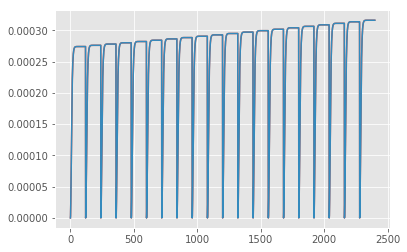

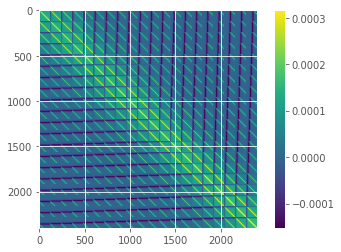

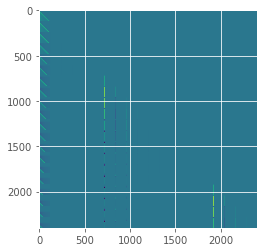

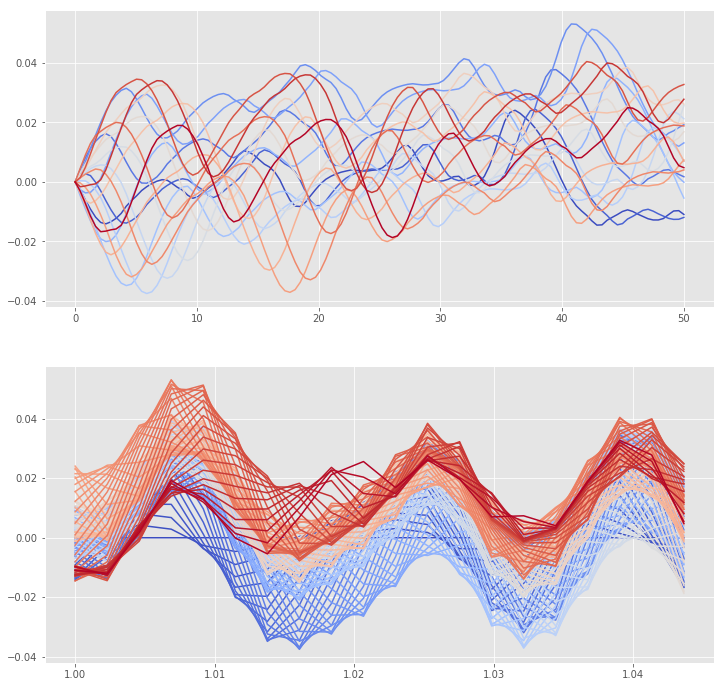

In [5]:
a = 400
b = 20
l = 5
K=ThinLayer([0,0,0],a,b,l)

x = np.linspace(0,50,120)
phi = 1+np.linspace(0.,2.5*np.pi/180.,20)
xi = np.stack([x,x,0*x],axis=1)
k = np.stack([np.sin(phi),0*phi,np.cos(phi)],axis=1)
X = make_coord_array(k[:,2:3],xi)
cov=K.compute_K_symm(X)
diag = K.compute_Kdiag(X)
plt.plot(np.diag(cov))
plt.plot(diag)
plt.show()
tec_scale = 0.001
L = tec_scale * np.linalg.cholesky(cov/tec_scale**2 + 1e-6*np.eye(cov.shape[0]))

plt.imshow(cov)
plt.colorbar()
plt.show()
plt.imshow(L)
plt.show()

Z = np.random.normal(size=(x.size,phi.size,)).T
sample = np.einsum("ab,b->a",L,Z.flatten()).reshape((phi.size,x.size))

import matplotlib as mpl
import matplotlib.cm as cm
plt.style.use('ggplot')

fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,12),sharey=True)
cmap = cm.coolwarm

norm = mpl.colors.Normalize(vmin=phi.min(), vmax=phi.max())
m = cm.ScalarMappable(norm=norm, cmap=cmap)
[axs[0].plot(x,sample[i,:],c=m.to_rgba(phi[i])) for i in range(len(phi))]

norm = mpl.colors.Normalize(vmin=x.min(), vmax=x.max())
m = cm.ScalarMappable(norm=norm, cmap=cmap)
[axs[1].plot(phi,sample.T[i,:],c=m.to_rgba(x[i])) for i in range(len(x))]

plt.show()

In [6]:
x = np.linspace(0,100,120)
phi = np.linspace(0,2.5*np.pi/180.,20)
xi = np.stack([x,x,0*x],axis=1)
k = np.stack([np.sin(phi),0*phi,np.cos(phi)],axis=1)
X = make_coord_array(xi,k)

a = 400. # layer height in km
b = 20. # layer thickness in km
l = 10. * np.array([1,1,1]) # irregularity scales
x0 = xi[:1,:] # reference antenna
sigma = 0.1 # log-electron noise
cov = kern(X,a,b,x0,sigma,l)

plt.plot(np.diag(cov))
plt.plot(diag)
plt.show()

tec_scale = 0.001
L = tec_scale * np.linalg.cholesky(cov/tec_scale**2 + 1e-6*np.eye(cov.shape[0]))

plt.imshow(cov)
plt.colorbar()
plt.show()
plt.imshow(L)
plt.show()


# np.random.seed(0)
sample = np.einsum("ab,b->a",L,Z.flatten()).reshape((x.size,phi.size))

import matplotlib as mpl
import matplotlib.cm as cm
plt.style.use('ggplot')

fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,12),sharey=True)
cmap = cm.coolwarm

norm = mpl.colors.Normalize(vmin=phi.min(), vmax=phi.max())
m = cm.ScalarMappable(norm=norm, cmap=cmap)
[axs[0].plot(x,sample[:,i],c=m.to_rgba(phi[i])) for i in range(len(phi))]

norm = mpl.colors.Normalize(vmin=x.min(), vmax=x.max())
m = cm.ScalarMappable(norm=norm, cmap=cmap)
[axs[1].plot(phi,sample.T[:,i],c=m.to_rgba(x[i])) for i in range(len(x))]

plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 1